## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
import LossFunctions: HuberLoss, value
import Distributions: Chisq,ccdf
import StatsBase: mad, sample

function huberize(y::Vector{Float64})
    m = median(y)
    s = mad(y,normalize=true)
    z = (y.-m)./s
    l = value.(HuberLoss(1),z)
    x = sign.(z).* sqrt.(2*l)
    return m .+ s.*x
end

huberize (generic function with 1 method)

## Load processed_data:

### By individuals:

In [5]:
BXD_pheno_ind_summary_df = CSV.read("data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [6]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [7]:
names(BXD_pheno_ind_summary_df)[7515]

"P61924_VALRGEDVPLTEQTVSQVLQSAK_3"

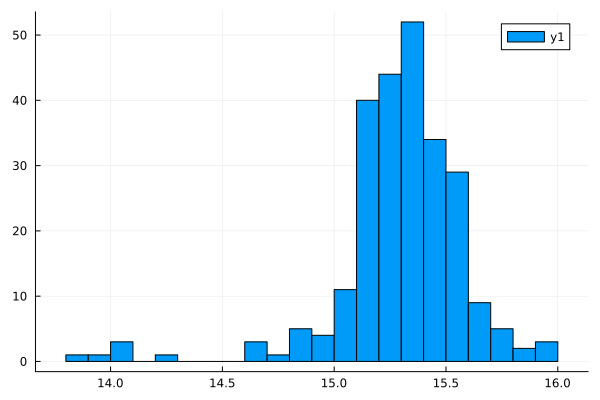

In [8]:
histogram(BXD_pheno_ind_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

In [9]:
BXD_geno_ind_summary_df = CSV.read("data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [10]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Huberized individual LPs:

In [11]:
BXD_pheno_huber_ind_summary_df = CSV.read("data/GN886_pheno_huber_summary.csv", DataFrame);

In [12]:
println(size(BXD_pheno_huber_ind_summary_df)) 
BXD_pheno_huber_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.35,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.2619,12.6093,17.4271,17.3294,17.252,16.685,16.0223
3,H2577,BXD9,9,12.415,10.5848,17.8852,17.488,17.5905,16.731,16.208
4,H0365,BXD9,9,11.3741,10.7134,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.3718,17.3671,17.096,16.4699,15.9795
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.8432,17.416,17.0223,16.292
8,H1791,BXD24,24,12.5,12.2701,17.9262,17.8312,17.6187,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


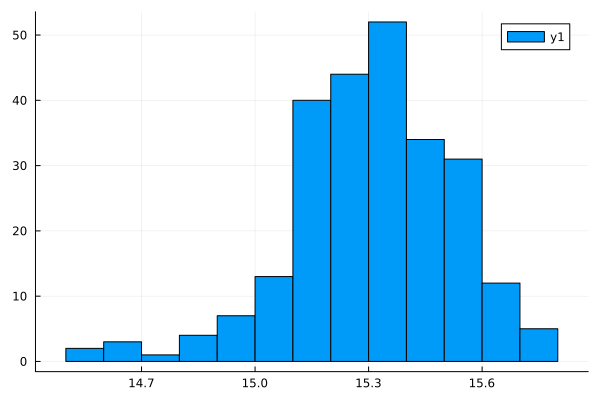

In [13]:
histogram(BXD_pheno_huber_ind_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

### By strains:

In [14]:
BXD_pheno_strains_summary_df = CSV.read("data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [15]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


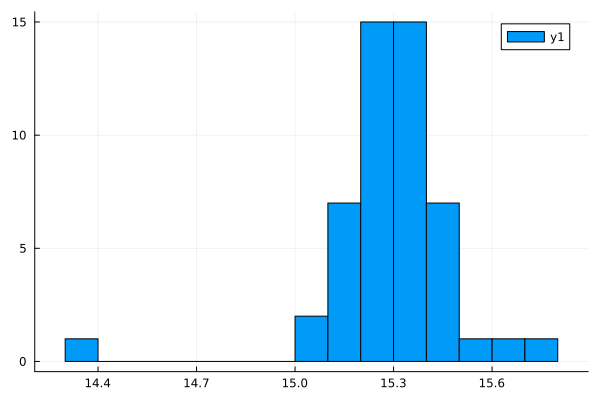

In [16]:
histogram(BXD_pheno_strains_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

In [17]:
BXD_geno_strains_summary_df = CSV.read("data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [18]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Huberized strain means LPs:

In [19]:
# BXD_pheno_huber_strains_summary_df = CSV.read("data/GN886_pheno_huber_strain_means_summary.csv", DataFrame);

In [20]:
# println(size(BXD_pheno_huber_strains_summary_df)) 
# BXD_pheno_huber_strains_summary_df[1:10, 1:10]

In [21]:
# histogram(BXD_pheno_huber_strains_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

In [22]:
# mean(BXD_pheno_huber_ind_summary_df[1:4, 4])

In [23]:
# mean(BXD_pheno_huber_ind_summary_df[11:13, 4])

## Load functions:

In [24]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [25]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [26]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [27]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [28]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [29]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [30]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000228 seconds (76 allocations: 503.766 KiB)


Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [31]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [32]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  3.408009 seconds (306.28 k allocations: 8.368 GiB, 6.11% gc time)


In [33]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 7512-th livear proteomic as the single trait to run analysis:  

In [34]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [35]:
lp_id = 7512;
lp_names[lp_id]

"P61924_VALRGEDVPLTEQTVSQVLQSAK_3"

#### For individual liver proteome

In [36]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [37]:
## Huberized individuals data:
lp_ind_Y_hub = Matrix{Float64}(BXD_pheno_huber_ind_summary_df[:, 4:end]);
lp_ind_y_hub = reshape(lp_ind_Y_hub[:, lp_id], :, 1);

In [38]:
lpst_ind_Y = colStandardize(lp_ind_Y);
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);
lpst_ind_Y_hub = colStandardize(lp_ind_Y_hub);
lpst_ind_y_hub = reshape(lpst_ind_Y_hub[:, lp_id], :, 1);

In [39]:
@time scan_results_ind = scan(lp_ind_y, geno_ind, kinship_ind_from_strains);

  0.213539 seconds (80.92 k allocations: 134.882 MiB, 25.49% gc time)


In [40]:
@time scan_results_ind_alt = scan(lp_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt");

  4.348013 seconds (3.85 M allocations: 4.786 GiB, 7.07% gc time)


In [41]:
@time scan_st_results_ind_alt = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt", 
                                  prior_variance = 1.0, prior_sample_size = 0.1);

  4.197292 seconds (3.73 M allocations: 4.639 GiB, 7.28% gc time)


##### Huberized...

In [42]:
@time scan_results_ind_hub = scan(lp_ind_y_hub, geno_ind, kinship_ind_from_strains);

  0.134654 seconds (81.08 k allocations: 135.064 MiB)


In [43]:
@time scan_results_ind_alt_hub = scan(lp_ind_y_hub, geno_ind, kinship_ind_from_strains;
                                      assumption = "alt");

  7.524852 seconds (6.83 M allocations: 8.480 GiB, 7.10% gc time)


In [44]:
@time scan_st_results_ind_alt_hub = scan(lpst_ind_y_hub, geno_ind, kinship_ind_from_strains;
                                         assumption = "alt",
                                         prior_variance = 1.0, prior_sample_size = 0.1);

  7.634985 seconds (6.83 M allocations: 8.480 GiB, 7.08% gc time)


In [45]:
scan_results_ind_hub.h2_null

0.06452496649941293

In [46]:
scan_results_ind_alt_hub.h2_null

0.06452496649941293

In [47]:
scan_st_results_ind_alt_hub.h2_null

0.06451099855679913

In [48]:
hcat(scan_results_ind_alt.lod, scan_results_ind_alt_hub.lod)

7321×2 Matrix{Float64}:
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.232151  0.119197
 0.224441  0.134353
 ⋮         
 0.700907  0.947232
 0.700907  0.947232
 0.700907  0.947232
 0.636675  0.845281
 0.523869  0.69563
 0.523869  0.69563
 0.562377  0.767873
 0.598874  0.816178
 0.562377  0.767873
 0.598874  0.816178
 0.467374  0.637581
 0.467374  0.637581

In [49]:
@time scan_perms_results_ind = scan(lp_ind_y, geno_ind, kinship_ind_from_strains;
                                    permutation_test = true, nperms = 1000, original = true);

  0.932690 seconds (1.91 M allocations: 259.265 MiB, 3.79% gc time, 86.69% compilation time)


#### For liver proteome means by strains

In [50]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [51]:
lpst_strains_Y = colStandardize(lp_strains_Y);
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

(strain means of the huberized individual liver proteome...)

In [52]:
# lp_strains_Y_hub = Matrix{Float64}(BXD_pheno_huber_strains_summary_df[:, 3:end]);
# lp_strains_y_hub = reshape(lp_strains_Y_hub[:, lp_id], :, 1);

Instead, take the strain means from the original individual data, and then apply huberization:

In [53]:
@time lp_strains_Y_hub = map(x -> huberize(lp_strains_Y[:, x]), 1:size(lp_strains_Y, 2));
@time lp_strains_Y_hub = reduce(hcat, lp_strains_Y_hub);
lp_strains_y_hub = reshape(lp_strains_Y_hub[:, lp_id], :, 1);

  0.517380 seconds (1.46 M allocations: 182.745 MiB, 12.27% gc time, 62.32% compilation time)
  0.049727 seconds (87.29 k allocations: 17.325 MiB, 86.69% compilation time)


In [55]:
BXD_strain_means_huberized_summary_df = DataFrame(
    hcat(Matrix{Any}(BXD_pheno_strains_summary_df[:, 1:2]), lp_strains_Y_hub),
    names(BXD_pheno_strains_summary_df));

CSV.write("data/GN886_pheno_huber_strain_means_summary.csv", BXD_strain_means_huberized_summary_df);

In [56]:
lpst_strains_Y_hub = colStandardize(lp_strains_Y_hub);
lpst_strains_y_hub = reshape(lpst_strains_Y_hub[:, lp_id], :, 1);

In [57]:
@time scan_results_strains = scan(lp_strains_y, geno_strains, kinship_strains);

  0.039662 seconds (82.15 k allocations: 32.632 MiB)


In [58]:
@time scan_results_strains_alt = scan(lp_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt");

  4.344922 seconds (10.18 M allocations: 3.166 GiB, 17.64% gc time)


##### Huberized... 

In [59]:
@time scan_results_strains_hub = scan(lp_strains_y_hub, geno_strains, kinship_strains);

  0.049946 seconds (80.89 k allocations: 32.287 MiB)


In [60]:
@time scan_results_strains_alt_hub = scan(lp_strains_y_hub, geno_strains, kinship_strains;
                                          assumption = "alt");

  2.209976 seconds (5.64 M allocations: 1.753 GiB, 8.33% gc time)


In [61]:
@time scan_results_strains_alt_hub_c = scan(lp_strains_y_hub, geno_strains, kinship_strains;
                                          assumption = "alt",  
                                          prior_variance = var(lp_strains_y_hub), 
                                          prior_sample_size = 0.1);

  2.413712 seconds (5.96 M allocations: 1.827 GiB, 11.92% gc time, 2.07% compilation time)


In [62]:
scan_results_strains_alt_hub.h2_null

0.6011922559652536

In [63]:
scan_results_strains_alt_hub_c.h2_null # Bayes Corrected

0.5794317678991349

In [64]:
hcat(scan_results_strains_alt.lod, scan_results_strains_alt_hub.lod)

7321×2 Matrix{Float64}:
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.232254  0.141084
 -0.203384  0.155486
  ⋮         
  1.12186   1.50983
  1.12186   1.50983
  1.12186   1.50983
  1.074     1.43546
  0.988229  1.31049
  0.988229  1.31049
  1.03307   1.38463
  1.12923   1.52862
  1.03307   1.38463
  1.12923   1.52862
  0.853909  1.12059
  0.853909  1.12059

In [65]:
any(scan_results_strains_alt_hub.lod .< 0.0)

false

In [66]:
@time scan_perms_results_strains = scan(lp_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true);

  0.130835 seconds (91.29 k allocations: 79.023 MiB, 71.94% gc time)


### Multiple-trait genome scans:

In [67]:
BLAS.set_num_threads(16)

In [68]:
BLAS.get_num_threads()

16

In [69]:
grid_list = collect(0.0:0.05:0.95);

#### For individual liver proteome

In [70]:
@benchmark bulkscan_null_grid(lp_ind_Y_hub, geno_ind, kinship_ind_from_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.118 s (10.77% GC) to evaluate,
 with a memory estimate of 11.67 GiB, over 10097672 allocations.

In [71]:
@time bulkscan_results_null_ind = bulkscan_null(lp_ind_Y_hub, geno_ind, kinship_ind_from_strains; nb = 16);

148.710614 seconds (2.60 G allocations: 1.813 TiB, 17.29% gc time, 0.04% compilation time)


In [72]:
BLAS.set_num_threads(16)

In [73]:
@benchmark bulkscan_alt_grid(lp_ind_Y_hub, geno_ind, kinship_ind_from_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 22.616 s (3.37% GC) to evaluate,
 with a memory estimate of 41.84 GiB, over 8691530 allocations.

In [74]:
@time bulkscan_results_ind = bulkscan_null_grid(lp_ind_Y_hub, geno_ind, kinship_ind_from_strains, grid_list);

  5.639697 seconds (10.10 M allocations: 11.669 GiB, 3.99% gc time)


#### For liver proteome means by strains

In [75]:
@benchmark bulkscan_null_grid(lp_strains_Y_hub, geno_strains, kinship_strains, grid_list)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.712 s …   2.736 s  ┊ GC (min … max): 4.41% … 5.10%
 Time  (median):     2.724 s              ┊ GC (median):    4.75%
 Time  (mean ± σ):   2.724 s ± 17.293 ms  ┊ GC (mean ± σ):  4.75% ± 0.49%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.71 s         Histogram: frequency by time        2.74 s <

 Memory estimate: 5.33 GiB, allocs estimate: 9632333.

In [76]:
@time bulkscan_results_null_strains = bulkscan_null(lp_strains_Y_hub, geno_strains, kinship_strains);

 56.029306 seconds (2.61 G allocations: 434.355 GiB, 42.58% gc time)


In [77]:
BLAS.set_num_threads(16)

In [78]:
@benchmark bulkscan_alt_grid(lp_strains_Y_hub, geno_strains, kinship_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 15.772 s (3.13% GC) to evaluate,
 with a memory estimate of 36.86 GiB, over 8691545 allocations.

In [79]:
grid_list = collect(0.0:0.05:0.95);

In [80]:
@time bulkscan_results_strains = bulkscan_null_grid(lp_strains_Y_hub, geno_strains, kinship_strains, grid_list);

  3.158366 seconds (9.63 M allocations: 5.332 GiB, 4.68% gc time)


In [81]:
hcat(scan_results_ind_hub.lod, bulkscan_results_ind[3][:, lp_id], 
     scan_results_strains_hub.lod, bulkscan_results_strains[3][:, lp_id]) |> 
(x -> DataFrame(x, ["LOD_ind", "LOD_ind_grid",  "LOD_strains", "LOD_strains_grid"])) |> x -> x[1:10, :]

Row,LOD_ind,LOD_ind_grid,LOD_strains,LOD_strains_grid
,Float64,Float64,Float64,Float64
1,0.116277,0.0729695,0.106625,0.00255342
2,0.116277,0.0729695,0.106625,0.00255342
3,0.116277,0.0729695,0.106625,0.00255342
4,0.116277,0.0729695,0.106625,0.00255342
5,0.116277,0.0729695,0.106625,0.00255342
6,0.116277,0.0729695,0.106625,0.00255342
7,0.116277,0.0729695,0.106625,0.00255342
8,0.116277,0.0729695,0.106625,0.00255342
9,0.116277,0.0729695,0.106625,0.00255342


In [108]:
maximum(abs.(scan_results_strains_hub.lod .- bulkscan_results_strains[3][:, lp_id]))

0.7963885183852386

In [109]:
h2_taken_ind = bulkscan_results_ind[1];
h2_taken_strains = bulkscan_results_strains[1];

In [110]:
bulkscan_results_ind[2]

20-element Vector{Float64}:
 0.0
 0.2
 0.4
 0.45
 0.5
 0.15
 0.35
 0.3
 0.6
 0.25
 0.7
 0.1
 0.75
 0.9
 0.95
 0.55
 0.8
 0.05
 0.85
 0.65

In [111]:
function get_h2_distribution(h2_list::Array{Float64, 1}, idxs_by_bin::Vector{Vector{Bool}})

    h2_distr = zeros(size(idxs_by_bin[1], 1));
    
    for i in 1:length(h2_list)
        h2_distr[idxs_by_bin[i]] .= h2_list[i]
    end
    
    return h2_distr;
    
end

get_h2_distribution (generic function with 1 method)

In [112]:
h2_distr_ind = get_h2_distribution(bulkscan_results_ind[2], h2_taken_ind);
h2_distr_strains = get_h2_distribution(bulkscan_results_strains[2], h2_taken_strains);

In [113]:
h2_distr_ind

32445-element Vector{Float64}:
 0.15
 0.1
 0.45
 0.65
 0.35
 0.5
 0.25
 0.45
 0.35
 0.3
 0.1
 0.0
 0.4
 ⋮
 0.0
 0.0
 0.0
 0.75
 0.0
 0.0
 0.0
 0.1
 0.0
 0.15
 0.0
 0.0

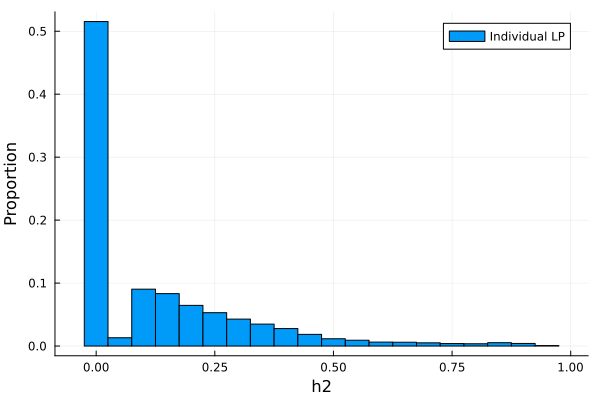

In [114]:
hist_ind = histogram(h2_distr_ind, normalize = :probability,
          label = "Individual LP", xlab = "h2", ylab = "Proportion", bins = -0.025:0.05:1.00)

In [89]:
function univar_liteqtl_c(y0_j::AbstractArray{Float64, 1}, X0_intercept::AbstractArray{Float64, 2}, 
    X0_covar::AbstractArray{Float64, 2}, lambda0::AbstractArray{Float64, 1}; 
    prior_variance = 0.0, prior_sample_size = 0.0,
    reml::Bool = false)

    n = size(y0_j, 1);
    y0 = reshape(y0_j, :, 1);

    # estimate the heritability from the null model and apply it to the reweighting of all markers;
    vc = fitlmm(y0, X0_intercept, lambda0, [prior_variance, prior_sample_size]; reml = reml);
    sqrtw = sqrt.(abs.(makeweights(vc.h2, lambda0)));

    # re-weight the data; then in theory, the observations are homoskedestic and independent.
    wy0 = rowMultiply(y0, sqrtw);
    wX0_intercept = rowMultiply(X0_intercept, sqrtw);
    wX0_covar = rowMultiply(X0_covar, sqrtw);

    R = computeR_LMM(wy0, wX0_covar, wX0_intercept);
    threaded_map!(r2lod, R, n; dims = 2);

    return (R = R, h2 = vc.h2); # results will be p-by-1, i.e. all LOD scores for the j-th trait and p markers

end

univar_liteqtl_c (generic function with 1 method)

In [90]:
function bulkscan_null_c(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2};
                   nb::Int64 = Threads.nthreads(), 
                   nt_blas::Int64 = 1, prior_variance = 1.0, prior_sample_size = 0.0,
                   reml::Bool = false)


    m = size(Y, 2);
    p = size(G, 2);

    BLAS.set_num_threads(nt_blas);

    # rotate data
    (Y0, X0, lambda0) = transform_rotation(Y, G, K);
    X0_intercept = reshape(X0[:, 1], :, 1);
    X0_covar = X0[:, 2:end];

    # distribute the `m` traits equally to every block
    (len, rem) = divrem(m, nb);

    results = Array{Array{Float64, 2}, 1}(undef, nb);
    h2_null_list = zeros(m);

    Threads.@threads for t = 1:nb # so the N blocks will share the (nthreads - N) BLAS threads

        lods_currBlock = Array{Float64, 2}(undef, p, len);

        # process every trait in the block by a @simd loop 
        @simd for i = 1:len
            j = i+(t-1)*len;

            outputs = univar_liteqtl_c(Y0[:, j], X0_intercept, X0_covar, lambda0; 
                                                              prior_variance = prior_variance, prior_sample_size = prior_sample_size,
                                                              reml = reml);
            @inbounds lods_currBlock[:, i] = outputs.R;
            @inbounds h2_null_list[j] = outputs.h2 
        end

        results[t] = lods_currBlock;

    end

    LODs_all = reduce(hcat, results);

    # if no remainder as the result of blocking, no remaining traits need to be scanned
    if rem == 0
        return LODs_all
    end
        
    # else, process up the remaining traits
    lods_remBlock = Array{Float64, 2}(undef, p, rem);

    for i in 1:rem

        j = m-rem+i;

        outputs = univar_liteqtl_c(Y0[:, j], X0_intercept, X0_covar, lambda0;
                   reml = reml);
        
        lods_remBlock[:, i] = outputs.R;
        h2_null_list[j] = outputs.h2;

    end

    LODs_all = hcat(LODs_all, lods_remBlock);

    return (L = LODs_all, h2_null_list = h2_null_list)

end

bulkscan_null_c (generic function with 1 method)

In [91]:
@time test_bulkscan_null = bulkscan_null_c(lp_strains_Y_hub, geno_strains, kinship_strains);

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1minner_mapslices![22m[0m[1m([22m[90msafe_for_reuse[39m::[0mBool, [90mindices[39m::[0mBase.Iterators.Drop[90m{CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}[39m, [90mnidx[39m::[0mInt64, [90midx[39m::[0mVector[90m{Any}[39m, [90motherdims[39m::[0mVector[90m{Int64}[39m, [90mridx[39m::[0mVector[90m{Any}[39m, [90mAslice[39m::[0mVector[90m{Float64}[39m, [90mA[39m::[0mMatrix[90m{Float64}[39m, [90mf[39m::[0mvar"#26#28", [90mR[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m   @ [39m[90mBase[39m [90m./[39m[90m[4mabstractarray.jl:2834[24m[39m
     [2] [0m[1mmapslices[22m[0m[1m([22m[90mf[39m::[0mvar"#26#28", [90mA[39m::[0mMatrix[90m{Float64}[39m; [90mdims[39m::[0mInt64[0m[1m)[22m
    [90m   @ [39m[90mBase[39m [90m./[39m[90m[4mabstractarray.jl:2824[24m[39m
     [3] [0m[1mcomputeR_LMM[22m[0m[1m([22m[90mwY[39m::[0mMatrix[90m{Float64}[39m, [90mwX[39m::[0mMatrix[90m{Float64}[39m, [90mwIntercept[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m~/git/BulkLMM.jl/src/[39m[90m[4mbulkscan_helpers.jl:57[24m[39m
     [4] [0m[1munivar_liteqtl_c[22m[0m[1m([22m[90my0_j[39m::[0mVector[90m{Float64}[39m, [90mX0_intercept[39m::[0mMatrix[90m{Float64}[39m, [90mX0_covar[39m::[0mMatrix[90m{Float64}[39m, [90mlambda0[39m::[0mVector[90m{Float64}[39m; [90mprior_variance[39m::[0mFloat64, [90mprior_sample_size[39m::[0mFloat64, [90mreml[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mIn[89]:18[24m[39m
     [5] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mIn[90]:31[24m[39m[90m [inlined][39m
     [6] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
     [7] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mIn[90]:28[24m[39m[90m [inlined][39m
     [8] [0m[1m(::var"#263#threadsfor_fun#71"{Float64, Float64, Bool, Vector{Float64}, Vector{Matrix{Float64}}, Int64, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Int64, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [9] [0m[1m(::var"#263#threadsfor_fun#71"{Float64, Float64, Bool, Vector{Float64}, Vector{Matrix{Float64}}, Int64, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Int64, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [92]:
maximum(abs.(test_bulkscan_null.L .- bulkscan_results_null_strains))

LoadError: UndefVarError: test_bulkscan_null not defined

In [93]:
test_bulkscan_null.h2_null_list[lp_id]

LoadError: UndefVarError: test_bulkscan_null not defined

In [94]:
scan_results_strains.h2_null

5.545009081338703e-16

In [95]:
h2_distr_strains[lp_id]

0.0

In [96]:
maximum(abs.(test_bulkscan_null.L .- bulkscan_results_null_strains))

LoadError: UndefVarError: test_bulkscan_null not defined

In [97]:
hcat(bulkscan_results_strains[3][:, lp_id], test_bulkscan_null.L[:, lp_id])

LoadError: UndefVarError: test_bulkscan_null not defined

In [116]:
(lp_strains_y0, X0, lambda0) = transform_rotation(lp_strains_y_hub, geno_strains, kinship_strains);

In [120]:
scan_results_strains_hub.h2_null

0.6011922559652536

In [136]:
test = bulkscan_null_grid(lp_strains_y_hub, geno_strains, kinship_strains, vcat(grid_list, scan_results_strains_hub.h2_null));

In [137]:
test_h2_0 = weighted_liteqtl(lp_strains_y0, X0, lambda0, 0.0);
test_h2_06 = weighted_liteqtl(lp_strains_y0, X0, lambda0, scan_results_strains_hub.h2_null);
hcat(test_h2_0, test_h2_06, scan_results_strains_hub.lod)

7321×3 Matrix{Float64}:
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00255342  0.106625  0.106625
 0.00293048  0.110276  0.110276
 ⋮                     
 1.31237     1.0168    1.0168
 1.31237     1.0168    1.0168
 1.31237     1.0168    1.0168
 1.238       0.965602  0.965602
 1.11303     0.825586  0.825586
 1.11303     0.825586  0.825586
 1.18718     0.876094  0.876094
 1.33117     0.945266  0.945266
 1.18718     0.876094  0.876094
 1.33117     0.945266  0.945266
 0.923137    0.556789  0.556789
 0.923137    0.556789  0.556789

In [100]:
maximum(abs.(bulkscan_results_strains[3][:, lp_id].- test_bulkscan_null.L[:, lp_id]))

LoadError: UndefVarError: test_bulkscan_null not defined

In [101]:
h2_distr_strains[lp_id]

0.0

In [102]:
hcat(h2_distr_strains, round.(test_bulkscan_null.h2_null_list; digits = 2))

LoadError: UndefVarError: test_bulkscan_null not defined

In [103]:
mean(abs.(h2_distr_strains .- test_bulkscan_null.h2_null_list))

LoadError: UndefVarError: test_bulkscan_null not defined

In [104]:
scan(reshape(lp_strains_Y_hub[:, 6], :, 1), geno_strains, kinship_strains).h2_null

0.706558370839386

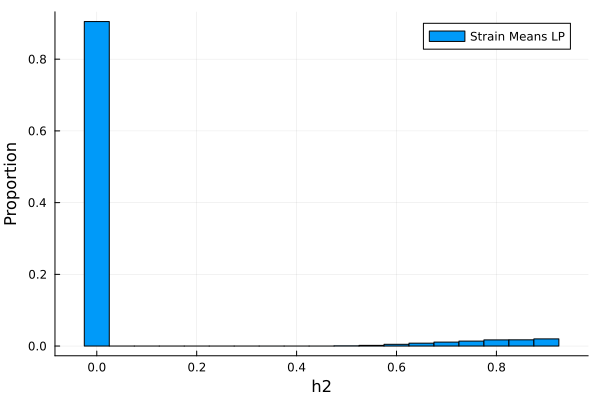

In [105]:
hist_strains = histogram(h2_distr_strains, normalize = :probability,
          label = "Strain Means LP", xlab = "h2", ylab = "Proportion", bins = -0.025:0.05:0.95)

In [ ]:
hcat(h2_distr_strains, h2_distr_ind)

## Run GEMMA for single-trait scans:

In [ ]:
pwd()

In [ ]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [ ]:
run(`$gemma -h`)

In [ ]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

In [ ]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

In [ ]:
lp_id

In [ ]:
transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GEMMA_data/GN886_geno_strains_summary.txt", 2);
transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GEMMA_data/GN886_geno_ind_summary.txt", 4);

In [ ]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_huber_strain_means_summary.csv", "data/GEMMA_data/GN886_pheno_huber_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_huber_summary.csv", "data/GEMMA_data/GN886_pheno_huber_ind_summary.txt", lp_id);

In [ ]:
writedlm("data/GEMMA_data/kinship_strains.txt", kinship_strains, '\t')
writedlm("data/GEMMA_data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [ ]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

In [ ]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_huber_strains_summary.txt", 
                   "data/GEMMA_data/GN886_geno_strains_summary.txt",
                   "data/GEMMA_data/kinship_strains.txt",
                   "results_strains.txt");

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_huber_ind_summary.txt", 
                   "data/GEMMA_data/GN886_geno_ind_summary.txt",
                   "data/GEMMA_data/kinship_ind.txt",
                   "results_ind.txt");

In [ ]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

In [ ]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [ ]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [ ]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [ ]:
hcat(gemma_ind_lod, scan_results_ind.lod)

In [ ]:
lookRange = 2001:4000

In [ ]:
lookRange = 1:7321

In [ ]:
plot(gemma_ind_lod[lookRange], label = "GEMMA_ind");
plot!(scan_results_ind_alt.lod[lookRange], label = "BulkLMM_ind")
# plot!(bulkscan_results_ind[3][lookRange, lp_id], label = "BulkLMM_ind_grid")

In [ ]:
scan_results_ind.h2_null

## Examine loglikelihood:

In [174]:
fitlmm(lp_strains_y0, reshape(X0[:, 1], :, 1), lambda0, [0.0, 0.0]).h2

0.601192247603648

In [178]:
w = makeweights(0.601192247603648, lambda0);
w_h0 = makeweights(0.0, lambda0);

In [177]:
wls(lp_strains_y0, reshape(X0[:, 1], :, 1), w, [0.0, 0.0]).ell

77.39200360919392

In [179]:
wls(lp_strains_y0, reshape(X0[:, 1], :, 1), w_h0, [0.0, 0.0]).ell

77.84666095466974

In [180]:
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
    # return (wls(y0, X0_inter, w, prior).ell, wls(y0, X0, w, prior).ell)
end

getLL (generic function with 1 method)

In [139]:
scan_results_ind.h2_null

0.109907911562461

In [162]:
var(lp_strains_y)

0.03383776164310895

In [163]:
ind_ll = map(x -> getLL(lp_ind_y, geno_ind, kinship_ind_from_strains, 1997, x), collect(0.0:0.001:0.999));
strains_ll = map(x -> getLL(lp_strains_y, geno_strains, kinship_strains, 1997, x; prior = [0.034, 0.1] ), collect(0.0:0.001:0.999));

In [164]:
ind_ell_list = zeros(999);
strains_ell_list = zeros(999);
for k in 1:999 
    ind_ell_list[k] = ind_ll[k].ll_null;
    strains_ell_list[k] = strains_ll[k].ll_null;
end

In [165]:
scan_results_strains_hub.h2_null

0.6011922559652536

In [166]:
getLL(lp_strains_y, geno_strains, kinship_strains, 1997, 0.6011922559652536)

(ll_null = 59.37881705701244, ll_markerID = 59.54740033410485)

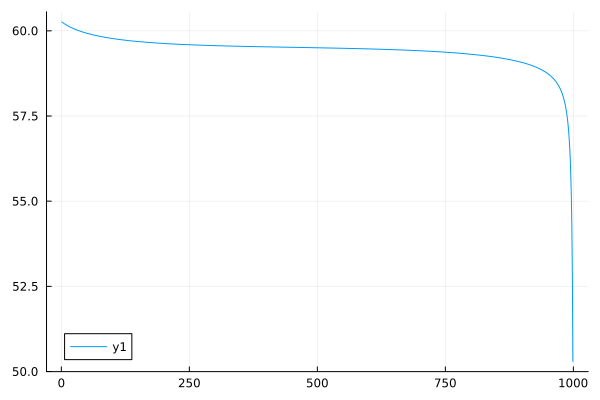

In [167]:
plot(strains_ell_list)

In [169]:
findmax(strains_ell_list)

(60.259124721479466, 1)

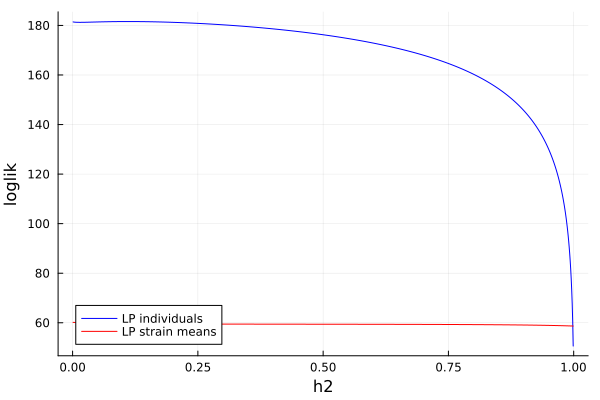

In [142]:
plot(collect(1:999).*0.001, ind_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP individuals", color = "blue", legend=:bottomleft)
plot!(collect(1:999).*0.001, strains_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP strain means", color = "red")